In [17]:
from __future__ import print_function

import keras
from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.datasets import imdb
from keras import optimizers
from keras.utils import np_utils

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

import numpy as np
import pandas as pd
import pickle, datetime

np.random.seed(0)

In [18]:
df = pd.read_csv('../Datasets/SST1_dataset/Processed_SST1.tsv', sep='\t')
train_df = pd.read_csv('../Datasets/Kaggle_dataset/train.tsv', sep='\t', header=0)

raw_docs_train      = df[df.split_ind == 1]['Phrases'].values
sentiment_train     = df[df.split_ind == 1]['Label'].values
# raw_docs_train      = train_df['Phrase'].values
# sentiment_train     = train_df['Sentiment'].values
raw_docs_test       = df[df.split_ind == 2]['Phrases'].values
sentiment_test      = df[df.split_ind == 2]['Label'].values
num_labels          = len(np.unique(sentiment_train))

N_TRAIN = len(raw_docs_train)
N_TEST = len(raw_docs_test)

In [19]:
#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_train.append(stemmed)

print ("pre-processing test docs...")
processed_docs_test = []
for doc in raw_docs_test:
   tokens = word_tokenize(doc)
   filtered = [word for word in tokens if word not in stop_words]
   stemmed = [stemmer.stem(word) for word in filtered]
   processed_docs_test.append(stemmed)
    
processed_docs_all = np.concatenate((processed_docs_train, processed_docs_test), axis=0)

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

word_id_test, word_ids = [], []
for doc in processed_docs_test:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_test.append(word_ids)
    word_id_len.append(len(word_ids))
        
seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
x_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
x_test  = sequence.pad_sequences(np.array(word_id_test), maxlen=seq_len)
y_train = np_utils.to_categorical(sentiment_train, num_labels)
y_test  = np_utils.to_categorical(sentiment_test, num_labels)

pre-processing train docs...
pre-processing test docs...
converting to token ids...


In [20]:
batch_size = 32
maxlen = seq_len
dictionary_size = len(dictionary.keys())

In [21]:
x_train.shape

(9645, 21)

In [22]:
print('Build model...')
embedding_dim = 25
lstm_units = 128

model_input = Input(shape =  (seq_len, ))

z = Embedding(dictionary_size, embedding_dim, 
              input_length=seq_len, 
              name="embedding", trainable=True)(model_input)

z = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)(z)
model_output = Dense(num_labels, activation='softmax')(z)

model = Model(model_input, model_output)
# try using different optimizers and different optimizer configs
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
embedding (Embedding)        (None, 21, 25)            345025    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               78848     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 424,518.0
Trainable params: 424,518.0
Non-trainable params: 0.0
_________________________________________________________________


In [23]:
from sklearn.metrics import roc_auc_score
import time
import pylab as pl
from IPython import display
pl.style.use('ggplot')
%matplotlib inline

class Histories(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs['acc'])
        self.loss.append(logs['loss'])
        self.val_acc.append(logs['val_acc'])
        self.val_loss.append(logs['val_loss'])
        
        pl.hold(True)
        pl.plot(self.acc, 'r')
        pl.plot(self.loss, 'g')
        pl.plot(self.val_acc, 'b')
        pl.plot(self.val_loss, 'k')
        pl.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
        display.clear_output(wait=True)
        display.display(pl.gcf())
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

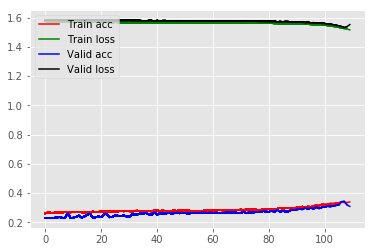

8s - loss: 1.5154 - acc: 0.3404 - val_loss: 1.5516 - val_acc: 0.3095


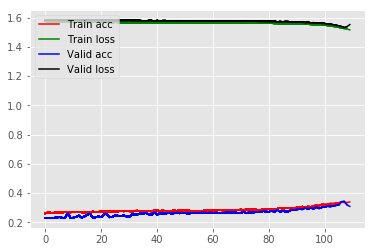

In [24]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(), metrics=["accuracy"])

histories = Histories()
res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=110,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [25]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("Train Accuracy: %.2f%%" % (scores[1]*100))
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Train Accuracy: 29.43%
Test Accuracy: 30.95%


In [27]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './newtrain_lstm' + '_' + date + '_' +time

with open( filename + '_history', 'wb') as output:
    pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)
    
model.save(filename + '.h5')

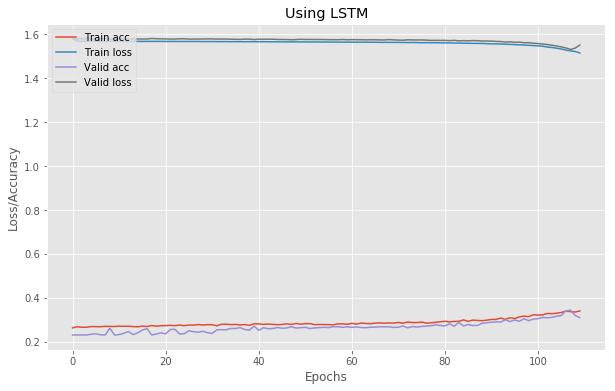

In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using LSTM')
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

In [36]:
import pickle

# filename = './newtrain_CNN-rand_2017-04-08_16:29:11'
model = keras.models.load_model(filename + '.h5')

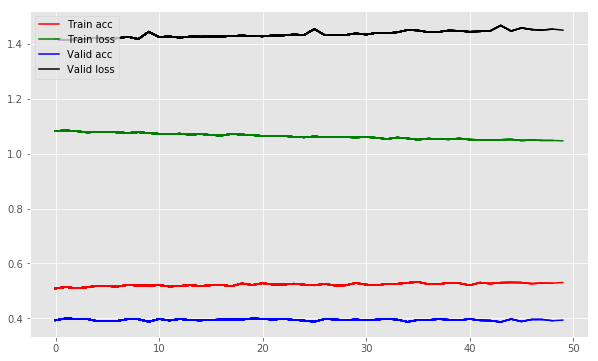

8s - loss: 1.0461 - acc: 0.5309 - val_loss: 1.4486 - val_acc: 0.3941


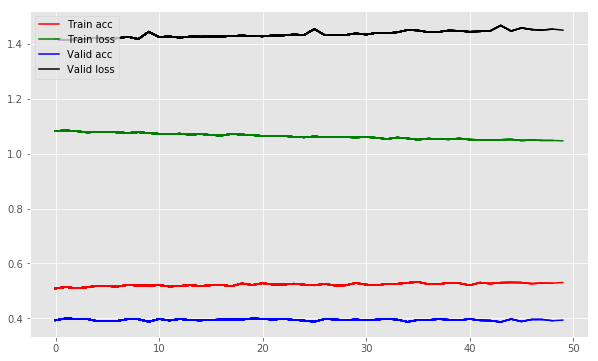

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(.001),
              metrics=['accuracy'])

histories = Histories()
res = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          validation_data=(x_test, y_test), verbose=2, callbacks=[histories])

In [38]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = './newtrain_continued_lstm'+ '_' + date + '_' +time

with open( filename + '_history', 'wb') as output:
    pickle.dump([model.history.history], output, pickle.HIGHEST_PROTOCOL)
    
model.save(filename + '.h5')

In [49]:
files = [
'newtrain_continued_lstm_2017-04-09_17:12:42_history',
    'newtrain_continued_lstm_2017-04-09_16:52:12_history',
'newtrain_lstm_2017-04-09_16:34:53_history'
]
files.reverse()

In [50]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    with open(file, 'rb') as input:
        out = pickle.load(input)
    hist = out[0]
    train_acc += hist['acc']
    train_loss += hist['loss']
    val_acc += hist['val_acc']
    val_loss += hist['val_loss']

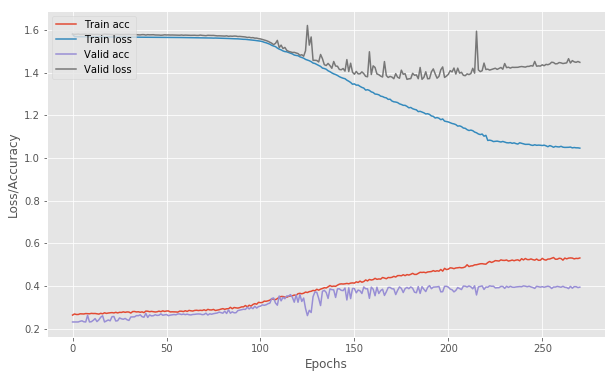

In [52]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()